In [1]:
import torch.nn as nn

# Residual block
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

# ConvMixer model with hard-coded parameters
def ConvMixer():
    dim = 256          # Embedding dimension
    depth = 8          # Number of ConvMixer blocks
    kernel_size = 5    # Kernel size for depthwise convolution
    patch_size = 4     # Patch size for initial convolution
    n_classes = 10     # CIFAR-10 has 10 classes

    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for _ in range(depth)],
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

In [12]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random
import random
from torch.utils.data import Subset, DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor()
])

train_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                 download=False, 
                                 transform=transform, 
                                 train=True)

test_dataset = datasets.CIFAR10(root='/home/j597s263/scratch/j597s263/Datasets/cifar10', 
                                download=False, 
                                transform=transform, 
                                train=False)

random.seed(42)  
train_indices = list(range(len(train_dataset)))
random.shuffle(train_indices)

split_idx = int(0.9 * len(train_indices))  
train_indices, attack_indices = train_indices[:split_idx], train_indices[split_idx:]

train_data = Subset(train_dataset, train_indices)
attack_data = Subset(train_dataset, attack_indices)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)  # Shuffle within batches
attack_loader = DataLoader(attack_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

print(f"Original training samples: {len(train_dataset)}")
print(f"Training samples after split: {len(train_data)}")
print(f"Attack samples: {len(attack_data)}")
print(f"Testing samples: {len(test_dataset)}")

# Load the model
model = torch.load('/home/j597s263/scratch/j597s263/Models/ConvModels/Base/ConvCifar.mod', weights_only=False, map_location="cuda:0")
model = model.to('cuda')
model.eval()
print("Model loaded successfully!")

Original training samples: 50000
Training samples after split: 45000
Attack samples: 5000
Testing samples: 10000
Model loaded successfully!


In [13]:
import numpy as np
import matplotlib.pyplot as plt

lime_explanations = np.load('/home/j597s263/scratch/j597s263/Datasets/Explanation_values/Conv/lime_ConvCif.npy', allow_pickle=True)

print(f"Number of explanations: {len(lime_explanations)}")
print(f"Example explanation: {lime_explanations[0]}")

Number of explanations: 5000
Example explanation: {'index': 0, 'label': 9, 'mask': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])}


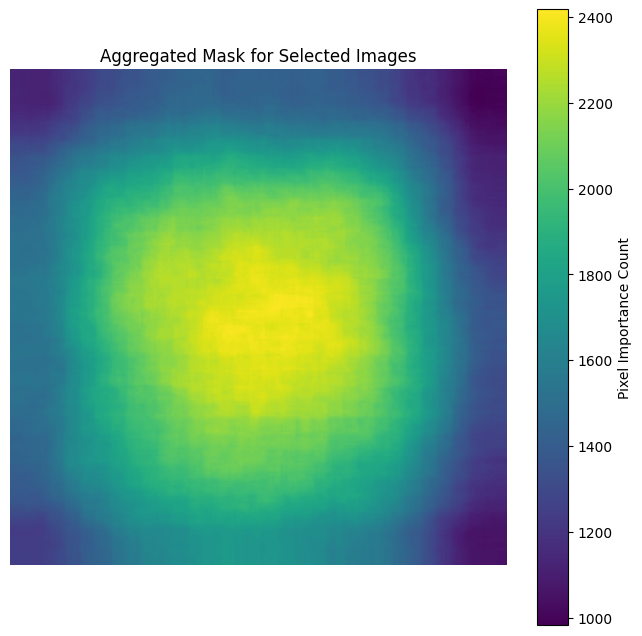

Aggregated Mask Summary:
Shape: (224, 224)
Unique Values: [ 982  983  984 ... 2411 2413 2418]


In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Indices of the selected images
selected_indices = list(range(len(lime_explanations)))  

# Initialize an empty array for aggregation
aggregated_mask = np.zeros_like(lime_explanations[0]['mask'], dtype=int)

# Sum the masks for the selected indices
for i in selected_indices:
    explanation = lime_explanations[i]
    mask = explanation['mask']  # Get the mask for the explanation
    aggregated_mask += mask  # Add the mask to the aggregated array

# Visualize the aggregated mask
plt.figure(figsize=(8, 8))
plt.imshow(aggregated_mask, cmap='viridis')  # Use a color map to highlight intensity
plt.title("Aggregated Mask for Selected Images")
plt.colorbar(label="Pixel Importance Count")
plt.axis('off')
plt.show()

# Print summary
print("Aggregated Mask Summary:")
print(f"Shape: {aggregated_mask.shape}")
print(f"Unique Values: {np.unique(aggregated_mask)}")


In [15]:
# Flatten the aggregated mask and get the indices of the top 22 values
flattened_mask = aggregated_mask.flatten()
top_22_indices = np.argsort(flattened_mask)[-22:][::-1]  # Indices of top 22 values, sorted in descending order

# Convert flattened indices to 2D coordinates
top_22_coords = np.unravel_index(top_22_indices, aggregated_mask.shape)
top_22_coords = list(zip(top_22_coords[0], top_22_coords[1]))

# Print the top 22 pixel coordinates and their values
print("Top 22 Pixel Locations and Their Values:")
for coord in top_22_coords:
    pixel_value = aggregated_mask[coord]
    print(f"Pixel {coord}: Value {pixel_value}")


Top 22 Pixel Locations and Their Values:
Pixel (np.int64(107), np.int64(121)): Value 2418
Pixel (np.int64(119), np.int64(99)): Value 2413
Pixel (np.int64(104), np.int64(129)): Value 2413
Pixel (np.int64(105), np.int64(121)): Value 2411
Pixel (np.int64(111), np.int64(135)): Value 2411
Pixel (np.int64(104), np.int64(122)): Value 2410
Pixel (np.int64(106), np.int64(121)): Value 2410
Pixel (np.int64(103), np.int64(122)): Value 2410
Pixel (np.int64(110), np.int64(135)): Value 2410
Pixel (np.int64(107), np.int64(127)): Value 2408
Pixel (np.int64(103), np.int64(129)): Value 2408
Pixel (np.int64(105), np.int64(133)): Value 2407
Pixel (np.int64(107), np.int64(120)): Value 2406
Pixel (np.int64(107), np.int64(119)): Value 2406
Pixel (np.int64(104), np.int64(121)): Value 2406
Pixel (np.int64(105), np.int64(122)): Value 2406
Pixel (np.int64(119), np.int64(100)): Value 2405
Pixel (np.int64(119), np.int64(98)): Value 2405
Pixel (np.int64(109), np.int64(117)): Value 2405
Pixel (np.int64(104), np.int64

In [17]:
import os
from PIL import Image
import torch
import torchvision.transforms as transforms

# Define the directory to save modified images
output_dir = "/home/j597s263/scratch/j597s263/Datasets/Attack/ConvLimeCif"
os.makedirs(output_dir, exist_ok=True)

# Define the top 22 pixel locations (your output from earlier)
top_22_coords = [
    (107, 121), (119, 99), (104, 129), (105, 121), (111, 135),
    (104, 122), (106, 121), (103, 122), (110, 135), (107, 127),
    (103, 129), (105, 133), (107, 120), (107, 119), (104, 121),
    (105, 122), (119, 100), (119, 98), (109, 117), (104, 133),
    (104, 130), (108, 120)
]

# Transformation to convert tensors back to images
to_pil = transforms.ToPILImage()

for idx, (batch_images, _) in enumerate(attack_loader):
    batch_images = batch_images.clone() 

    for img_idx, image_tensor in enumerate(batch_images):
        for x, y in top_22_coords:
            if 0 <= x < image_tensor.size(1) and 0 <= y < image_tensor.size(2):  
                image_tensor[:, x, y] = 0  

        # Convert tensor to PIL image and save
        pil_image = to_pil(image_tensor)
        output_path = os.path.join(output_dir, f"image_{idx * batch_images.size(0) + img_idx}.png")
        pil_image.save(output_path)

    print(f"Processed batch {idx+1}/{len(attack_loader)}")

print(f"Modified images saved to {output_dir}")

Processed batch 1/79
Processed batch 2/79
Processed batch 3/79
Processed batch 4/79
Processed batch 5/79
Processed batch 6/79
Processed batch 7/79
Processed batch 8/79
Processed batch 9/79
Processed batch 10/79
Processed batch 11/79
Processed batch 12/79
Processed batch 13/79
Processed batch 14/79
Processed batch 15/79
Processed batch 16/79
Processed batch 17/79
Processed batch 18/79
Processed batch 19/79
Processed batch 20/79
Processed batch 21/79
Processed batch 22/79
Processed batch 23/79
Processed batch 24/79
Processed batch 25/79
Processed batch 26/79
Processed batch 27/79
Processed batch 28/79
Processed batch 29/79
Processed batch 30/79
Processed batch 31/79
Processed batch 32/79
Processed batch 33/79
Processed batch 34/79
Processed batch 35/79
Processed batch 36/79
Processed batch 37/79
Processed batch 38/79
Processed batch 39/79
Processed batch 40/79
Processed batch 41/79
Processed batch 42/79
Processed batch 43/79
Processed batch 44/79
Processed batch 45/79
Processed batch 46/